In [1]:
##If you are running this notebook in Google Colab, you can comment/ignore the next two cells

In [2]:
!python -m ipykernel install --user --name=pyspark_env --display-name "Python (pyspark_env)"

Installed kernelspec pyspark_env in C:\Users\user\AppData\Roaming\jupyter\kernels\pyspark_env


In [3]:
##Click on kernel, change kernel and chosse python(pyspark_env)

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from pyspark.sql import functions as F

In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

In [7]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.appName("customer_seg1").getOrCreate()

### 0. Loading the data

In [8]:
# file path
file_path = "../data/processed/"
df_offers = spark.read.json(file_path + 'offers_processed.json')
all_clients = spark.read.json(file_path + 'clients_processed.json')
df_trans = spark.read.json(file_path + 'transactions_processed.json')

In [9]:
dftotal = df_trans.join(all_clients, on='client_id', how='left')

###1. Clustering all clients
In our clients dataset we have personal and commercial information such as `age` and `credit_card_limit`. Based solely on that, we can use an unsupervised algorithm called Kmeans to create groups os clients with similar features. We are going to use k=4 because our exploratory analysis suggests that there are 4 groups of clients.

In [10]:
feature_columns = ['age', 'credit_card_limit', 'number_of_transactions', 'total_spent', 'account_duration'] # features to cluster
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features") # combines multiple columns into a single vector column
df_features = assembler.transform(all_clients)

In [11]:
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)# scale the features (the ranges are very different)

scaler_model = scaler.fit(df_features)
allclients_scaled = scaler_model.transform(df_features)

In [12]:
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=4, seed=33)     # segmentation with k clusters

model = kmeans.fit(allclients_scaled)

In [13]:
predictions = model.transform(allclients_scaled)
predictions.select("age", "credit_card_limit", "cluster").show(10)

+---+-----------------+-------+
|age|credit_card_limit|cluster|
+---+-----------------+-------+
| 62|          73000.0|      0|
| 42|          57000.0|      1|
| 48|          75000.0|      3|
| 49|          36000.0|      1|
| 68|         115000.0|      0|
| 24|          53000.0|      1|
| 71|         108000.0|      0|
| 42|          51000.0|      1|
| 65|          56000.0|      0|
| 62|         111000.0|      0|
+---+-----------------+-------+
only showing top 10 rows



In [14]:
wssse = model.summary.trainingCost
print(f"Within Set Sum of Squared Errors = {wssse}")

Within Set Sum of Squared Errors = 34033.81106227461


In [15]:
pdf = predictions.select("number_of_transactions", "credit_card_limit", "cluster").toPandas()

<Axes: xlabel='number_of_transactions', ylabel='credit_card_limit'>

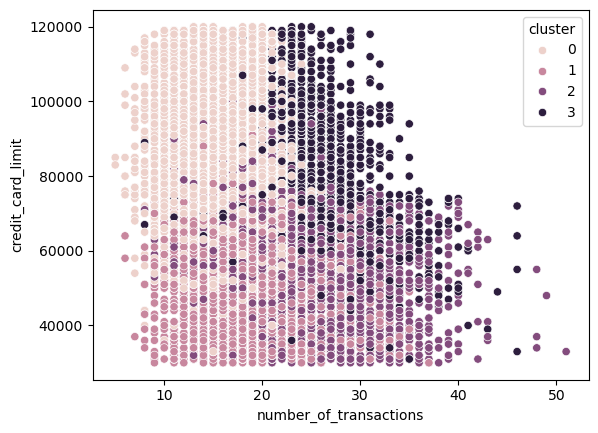

In [16]:
sns.scatterplot(data=pdf, x="number_of_transactions", y="credit_card_limit", hue='cluster')

As we can see above, the numeric features were able to creat reasonably well-separeted cluster of clients. But what about the clients that already have received an offer?

In [17]:
predictions.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 3521|
|      3| 1626|
|      2| 2624|
|      0| 4140|
+-------+-----+



####1.1 Checking the cluster
In this section, we want to check if inside a cluster, the clients received more or less the same offers.

In [18]:
cluster0 = predictions.filter(predictions.cluster == 0) # filtering clients in cluster 0

In [19]:
ids = cluster0.select('client_id').distinct().collect()# selecting the client_ids in cluster 0
ids0 = [row.client_id for row in ids]

In [20]:
trans0 = df_trans.filter(df_trans.client_id.isin(ids0))#filtering transactions of clients in cluster 0

In [21]:
trans0.groupBy('event').count().show()

+---------------+-----+
|          event|count|
+---------------+-----+
|    transaction|22921|
| offer received|17773|
|offer completed|10279|
|   offer viewed|13232|
+---------------+-----+



In [22]:
dftotal0 = dftotal.filter(dftotal.client_id.isin(ids0))

In [23]:
pdf = dftotal0.filter(trans0.event == 'offer completed').toPandas()

<Axes: xlabel='number_of_transactions', ylabel='credit_card_limit'>

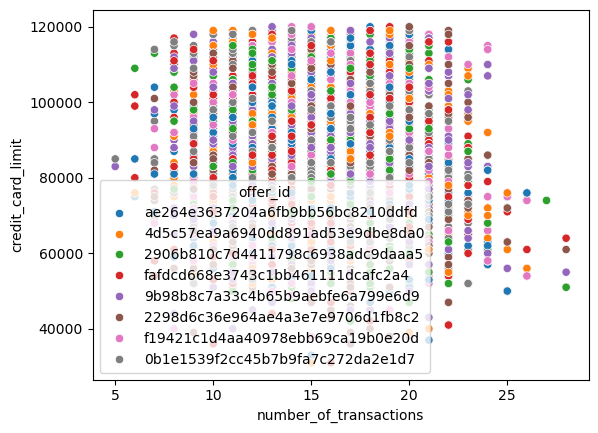

In [24]:
sns.scatterplot(data=pdf, x="number_of_transactions", y="credit_card_limit", hue='offer_id')

As we can see in the plot above, although our Kmeans was sucessfully able to segmentate the clients, the distribution of offers inside the cluster 0 is completely heterogeneous.

###2.Clustering the offers
In order to segmentate our custumers to create a distribution of offers strategy, we are going to cluster the offers. The idea is that similiar offers are going to be distributed to similar clients.

In [25]:
df_offers.show(10)

+--------------------+--------------+--------+--------------------+---------+-------------+
|            channels|discount_value|duration|                  id|min_value|   offer_type|
+--------------------+--------------+--------+--------------------+---------+-------------+
|email, mobile, so...|            10|     7.0|ae264e3637204a6fb...|       10|         bogo|
|web, email, mobil...|            10|     5.0|4d5c57ea9a6940dd8...|       10|         bogo|
|  web, email, mobile|             0|     4.0|3f207df678b143eea...|        0|informational|
|  web, email, mobile|             5|     7.0|9b98b8c7a33c4b65b...|        5|         bogo|
|          web, email|             5|    10.0|0b1e1539f2cc45b7b...|       20|     discount|
|web, email, mobil...|             3|     7.0|2298d6c36e964ae4a...|        7|     discount|
|web, email, mobil...|             2|    10.0|fafdcd668e3743c1b...|       10|     discount|
|email, mobile, so...|             0|     3.0|5a8bc65990b245e5a...|        0|inf

In [26]:
numeric_cols = ["discount_value", "duration", "min_value"]
categorical_cols = ["channels", "offer_type"]

In [27]:
# indexing categorical columns
for c in categorical_cols:
    indexer = StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="keep")
    indexer_model = indexer.fit(df_offers)       # fit on current df
    df_offers = indexer_model.transform(df_offers)



input_index_cols = [c + "_index" for c in categorical_cols]
output_vec_cols = [c + "_vec" for c in categorical_cols]

# encoding categorical columns
encoder = OneHotEncoder(inputCols=input_index_cols, outputCols=output_vec_cols, dropLast=True)
encoder_model = encoder.fit(df_offers)
df_offers = encoder_model.transform(df_offers)

# assembling all features
assembler_inputs = numeric_cols + output_vec_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_unscaled")
df_offers = assembler.transform(df_offers)   # adds features_unscaled

# scale the features
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=False)

In [28]:
scaler_model = scaler.fit(df_offers)
df = scaler_model.transform(df_offers)

In [29]:
k = 4
kmeans = KMeans(featuresCol="features", k=k, seed=88)
kmodel = kmeans.fit(df)

predictions = kmodel.transform(df)   # adds prediction column
predictions.select(['channels', 'offer_type', 'prediction', 'discount_value'] ).show(10, 0)

+--------------------------+-------------+----------+--------------+
|channels                  |offer_type   |prediction|discount_value|
+--------------------------+-------------+----------+--------------+
|email, mobile, social     |bogo         |1         |10            |
|web, email, mobile, social|bogo         |1         |10            |
|web, email, mobile        |informational|0         |0             |
|web, email, mobile        |bogo         |3         |5             |
|web, email                |discount     |2         |5             |
|web, email, mobile, social|discount     |1         |3             |
|web, email, mobile, social|discount     |1         |2             |
|email, mobile, social     |informational|0         |0             |
|web, email, mobile, social|bogo         |1         |5             |
|web, email, mobile        |discount     |3         |2             |
+--------------------------+-------------+----------+--------------+



In [30]:
df_offers = predictions.withColumnRenamed('prediction', 'group_offer')# rename columns
df_offers = df_offers.withColumnRenamed('id', 'offer_id')

In [31]:
offers_group = df_offers.select(['channels', 'offer_type','discount_value','offer_id', 'duration', 'min_value', 'group_offer'])

In [32]:
offers_group.select(['channels', 'offer_type','discount_value','duration', 'min_value', 'group_offer']).show(10, 0)

+--------------------------+-------------+--------------+--------+---------+-----------+
|channels                  |offer_type   |discount_value|duration|min_value|group_offer|
+--------------------------+-------------+--------------+--------+---------+-----------+
|email, mobile, social     |bogo         |10            |7.0     |10       |1          |
|web, email, mobile, social|bogo         |10            |5.0     |10       |1          |
|web, email, mobile        |informational|0             |4.0     |0        |0          |
|web, email, mobile        |bogo         |5             |7.0     |5        |3          |
|web, email                |discount     |5             |10.0    |20       |2          |
|web, email, mobile, social|discount     |3             |7.0     |7        |1          |
|web, email, mobile, social|discount     |2             |10.0    |10       |1          |
|email, mobile, social     |informational|0             |3.0     |0        |0          |
|web, email, mobile, 

In [33]:
df_offers = df_offers.select('offer_id', 'group_offer')

In [34]:
df_offers.groupBy('group_offer').count().show()

+-----------+-----+
|group_offer|count|
+-----------+-----+
|          1|    5|
|          3|    2|
|          2|    1|
|          0|    2|
+-----------+-----+



####2.1 Checking the clients cluster with the offers

In [35]:
pdf = dftotal0.filter(trans0.event == 'offer completed')

In [36]:
joined = df_offers.join(pdf, on='offer_id', how = 'left')

<Axes: xlabel='number_of_transactions', ylabel='credit_card_limit'>

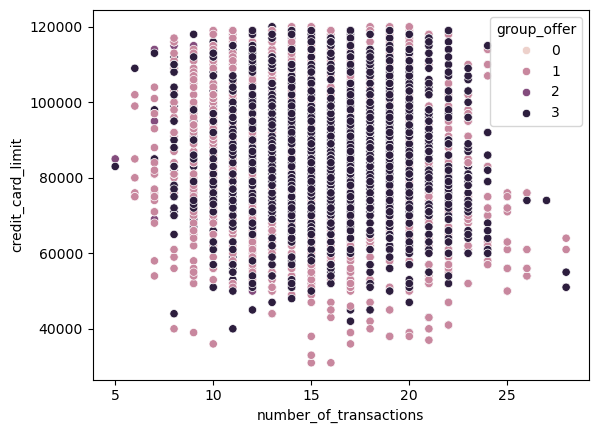

In [37]:
pdf = joined.toPandas()
sns.scatterplot(data=pdf, x='number_of_transactions', y='credit_card_limit', hue='group_offer')

The plot above is showing that grouping the clients without the offers information still create heterogeneous groups concerning the offers distribution.

In [38]:
pdf['group_offer'].value_counts()

group_offer
1    6465
3    2590
2    1224
0       2
Name: count, dtype: int64

###3. Biased Kmeans: clustering the clients with the offers information
In this section we are going to perform a "semi-supervised" Kmeans. Since our clients dataset already have information about offers for some clients but not all, we can take into account the labeled features of this clients and extend this idea to other clients.
In other words, we are going to use the information of a subset of clients who have the 'offer completed' or 'offer received' to bias our Kmeans.
Computing the 'most representative client' in each group who already has a offer label is a prior knowledge to all datasets.

In [39]:
df4 = dftotal.filter((dftotal.event == 'offer completed') | (dftotal.event == 'offer received'))#filter clients with offer_viewed or offer_completed
teste_join = df4.join(df_offers, on='offer_id', how='left')

teste2 = teste_join.select(['client_id','account_duration', 'age', 'credit_card_limit', 'number_of_transactions', 'total_spent','group_offer'])
df_labeled = teste2.select(['client_id', 'account_duration', 'age', 'credit_card_limit', 'number_of_transactions', 'total_spent', 'group_offer'])
df_unlabeled = all_clients.select(['client_id', 'account_duration', 'age', 'credit_card_limit', 'number_of_transactions', 'total_spent'])

In [40]:

# choose features and assemble
features = ['account_duration', 'age', 'credit_card_limit', 'number_of_transactions', 'total_spent']

assembler = VectorAssembler(inputCols=features, outputCol="features_raw")
df_labeled_vec = assembler.transform(df_labeled)

# add a dummy column in df_unlabeled so both dataframes have the same dimension
df_unlabeled_vec = assembler.transform(df_unlabeled) \
    .withColumn("group_offer", F.lit(None).cast("int"))


# scale features

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# fit scaler on data
scaler_model = scaler.fit(df_labeled_vec.unionByName(df_unlabeled_vec))

df_labeled_scaled = scaler_model.transform(df_labeled_vec)
df_unlabeled_scaled = scaler_model.transform(df_unlabeled_vec)

# compute centroids from labeled data

centroids_df = (
    df_labeled
    .groupBy("group_offer")
    .agg(*[F.avg(c).alias(c) for c in features])
)

# create dictionary with centroids to compute the distance
centroids = centroids_df.collect()
centroid_dict = {row["group_offer"]: [row[f] for f in features] for row in centroids}


# label the unlabeled data to nearest centroid
def nearest_centroid(features_vector):
    min_dist = float("inf")
    nearest = None
    for clust, center in centroid_dict.items():
        dist = sum((features_vector[i] - center[i])**2 for i in range(len(center)))**0.5
        if dist < min_dist:
            min_dist = dist
            nearest = clust
    return int(nearest)

nearest_centroid_udf = F.udf(nearest_centroid, "int")

df_unlabeled_with_cluster = df_unlabeled_scaled.withColumn(
    "group_offer",
    nearest_centroid_udf(F.col("features"))
)


# combine the two dataframes and run KMeans

df_all = df_labeled_scaled.unionByName(df_unlabeled_with_cluster)

kmeans = KMeans(
    k=len(centroid_dict),
    featuresCol="features",
    predictionCol="prediction",
    seed=42
)
model = kmeans.fit(df_all)

predictions = model.transform(df_all)

In [41]:
pdf = predictions.select("number_of_transactions", "credit_card_limit", "prediction").toPandas()

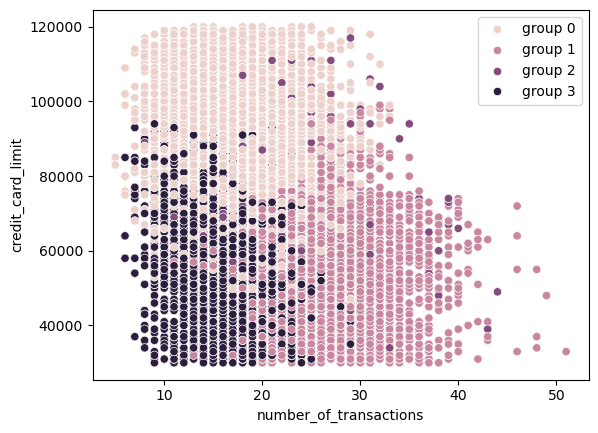

In [42]:
ax = sns.scatterplot(data=pdf, x="number_of_transactions", y="credit_card_limit", hue='prediction')

handles, labels = ax.get_legend_handles_labels()

new_labels = ['group 0', 'group 1','group 2', 'group 3']
plt.legend(handles=handles, labels=new_labels)
plt.show()

In [43]:
predictions.columns

['client_id',
 'account_duration',
 'age',
 'credit_card_limit',
 'number_of_transactions',
 'total_spent',
 'group_offer',
 'features_raw',
 'features',
 'prediction']

In [44]:
pdf = predictions.select("total_spent","age", "prediction").toPandas()

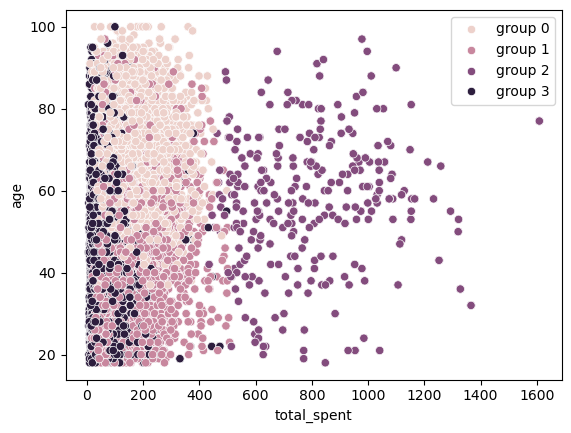

In [45]:
ax = sns.scatterplot(data=pdf, x="total_spent", y="age", hue='prediction')

handles, labels = ax.get_legend_handles_labels()

new_labels = ['group 0', 'group 1','group 2', 'group 3']
plt.legend(handles=handles, labels=new_labels)
plt.show()

With this model `model = kmeans.fit(df_all)` we can predict assign a cluster to any client.

In [46]:
type(predictions)

pyspark.sql.dataframe.DataFrame

In [ ]:
allpdf = predictions.toPandas()

In [ ]:
sns.pairplot(allpdf, hue='prediction')

###4. Checking the offers per cluster

In [48]:
client_seg = predictions.select(['client_id', 'account_duration', 'age', 'credit_card_limit','number_of_transactions',
 'total_spent','prediction'])
client_seg.show(5)

+--------------------+----------------+---+-----------------+----------------------+------------------+----------+
|           client_id|account_duration|age|credit_card_limit|number_of_transactions|       total_spent|prediction|
+--------------------+----------------+---+-----------------+----------------------+------------------+----------+
|78afa995795e4d85b...|             8.0| 75|         100000.0|                    18|            159.27|         0|
|e2127556f4f64592b...|             7.0| 68|          70000.0|                    12|57.730000000000004|         3|
|389bc3fa690240e79...|             7.0| 65|          53000.0|                    20|             36.43|         3|
|2eeac8d8feae4a8ca...|             8.0| 58|          51000.0|                    10|             15.62|         3|
|aa4862eba776480b8...|             8.0| 61|          57000.0|                    19|             85.55|         3|
+--------------------+----------------+---+-----------------+-------------------

In [49]:
client_seg.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|30942|
|         3|29725|
|         2| 2591|
|         0|35112|
+----------+-----+



In [50]:
clients0 = client_seg.filter(client_seg.prediction == 0).toPandas()
clients1 = client_seg.filter(client_seg.prediction == 1).toPandas()
clients2 = client_seg.filter(client_seg.prediction == 2).toPandas()
clients3 = client_seg.filter(client_seg.prediction == 3).toPandas()

####4.1 Cluster 0
A typical client in this group has the following characteristics:
- account of 7 years
- 19 transactions in average
- one out of two spends up to 76
- age between 34 and 57 years old
- 75% has `credit_card_limit` between 30k e 62k

In summary, they are younger clients, with fewer transactions and lower credit card limit and spents

In [51]:
clients0.describe()

,account_duration,age,credit_card_limit,number_of_transactions,total_spent,prediction
count,35112.000000,35112.000000,35112.000000,35112.000000,35112.000000,35112.0
mean,8.624146,65.936375,89008.487127,18.626595,164.564173,0.0
std,0.983079,12.292677,15145.426329,4.781981,77.861092,0.0
min,7.000000,36.000000,41000.000000,5.000000,11.100000,0.0
25%,8.000000,57.000000,78000.000000,15.000000,107.150000,0.0
50%,9.000000,65.000000,89000.000000,19.000000,155.660000,0.0
75%,9.000000,74.000000,99000.000000,22.000000,211.660000,0.0
max,12.000000,100.000000,120000.000000,33.000000,497.350000,0.0


The offers for this cluster are:

In [52]:
offers_group.filter(offers_group.group_offer == 0).show()

+--------------------+-------------+--------------+--------------------+--------+---------+-----------+
|            channels|   offer_type|discount_value|            offer_id|duration|min_value|group_offer|
+--------------------+-------------+--------------+--------------------+--------+---------+-----------+
|  web, email, mobile|informational|             0|3f207df678b143eea...|     4.0|        0|          0|
|email, mobile, so...|informational|             0|5a8bc65990b245e5a...|     3.0|        0|          0|
+--------------------+-------------+--------------+--------------------+--------+---------+-----------+



####4.2 Cluster 1
A typical client in this group has the following characteristics:
- account of 8 years in average
- Between 20 and 32 transactions
- 75% spends up to 445
- roughly 60 years old
- `credit_card_limit` highly concentrated between 70k and 100k

In summary, they have medium age, mediu number of transactions but high spends with high credit card limit.

In [53]:
clients1.describe()

,account_duration,age,credit_card_limit,number_of_transactions,total_spent,prediction
count,30942.000000,30942.000000,30942.000000,30942.000000,30942.000000,30942.0
mean,9.320406,48.073719,54820.502876,27.119158,154.843111,1.0
std,1.163773,16.429109,13998.454431,5.292570,92.928765,0.0
min,7.000000,18.000000,30000.000000,10.000000,16.970000,1.0
25%,8.000000,36.000000,44000.000000,24.000000,72.650000,1.0
50%,9.000000,48.000000,55000.000000,27.000000,145.280000,1.0
75%,10.000000,60.000000,65000.000000,30.000000,209.080000,1.0
max,12.000000,97.000000,100000.000000,51.000000,507.180000,1.0


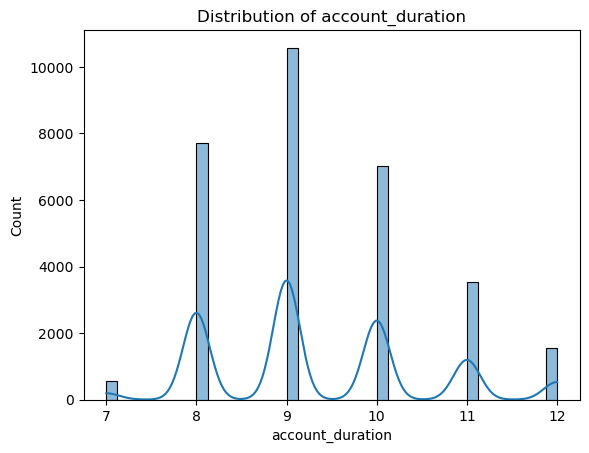

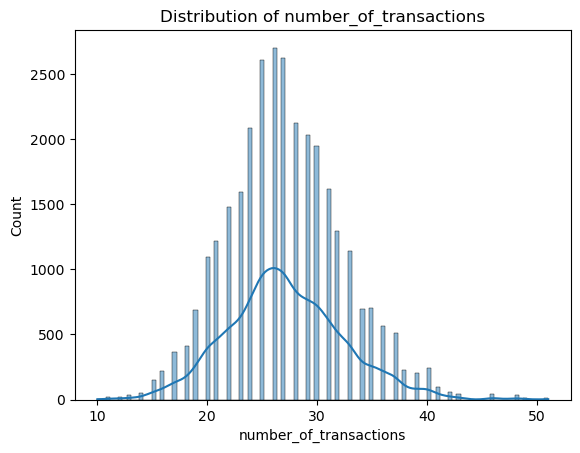

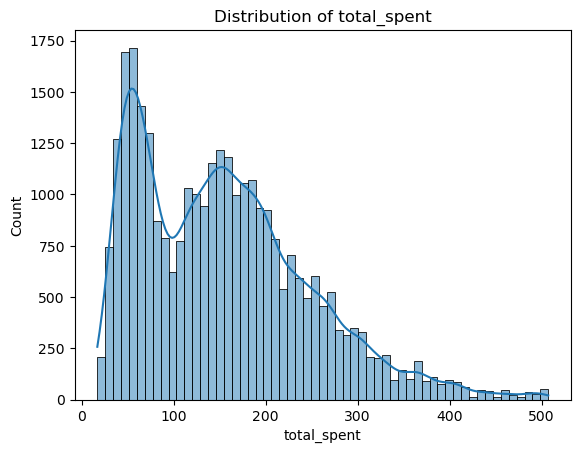

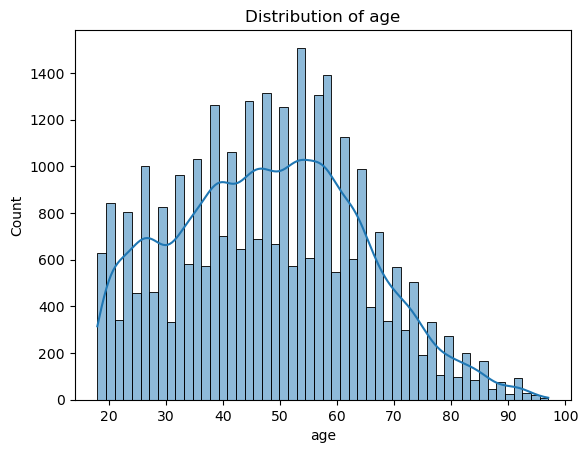

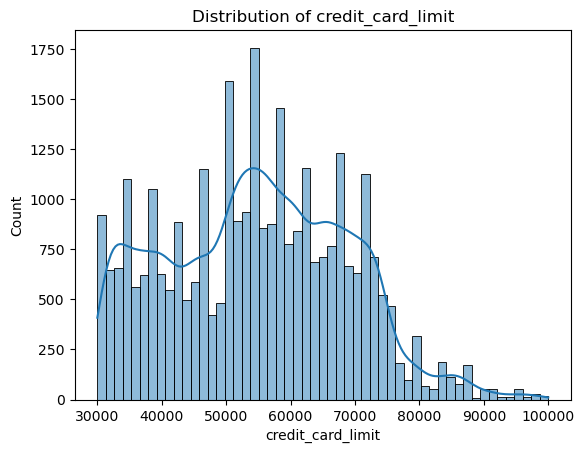

In [54]:
cols = ['account_duration', 'number_of_transactions', 'total_spent', 'age', 'credit_card_limit']

for col in cols:
    sns.histplot(clients1[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

The offers for this cluster are:

In [55]:
offers_group.filter(offers_group.group_offer == 1).show()

+--------------------+----------+--------------+--------------------+--------+---------+-----------+
|            channels|offer_type|discount_value|            offer_id|duration|min_value|group_offer|
+--------------------+----------+--------------+--------------------+--------+---------+-----------+
|email, mobile, so...|      bogo|            10|ae264e3637204a6fb...|     7.0|       10|          1|
|web, email, mobil...|      bogo|            10|4d5c57ea9a6940dd8...|     5.0|       10|          1|
|web, email, mobil...|  discount|             3|2298d6c36e964ae4a...|     7.0|        7|          1|
|web, email, mobil...|  discount|             2|fafdcd668e3743c1b...|    10.0|       10|          1|
|web, email, mobil...|      bogo|             5|f19421c1d4aa40978...|     5.0|        5|          1|
+--------------------+----------+--------------+--------------------+--------+---------+-----------+



####4.3 Cluster 2
A typical client in this group has the following characteristics:
- 8 years of account
- 65 years old in average
- 75% have `credit_card_limit` between 31k and 98k
- 16 transactions in average
- 50% spends up to 129

In summary, they do less transactions, low spends and medium credit card limit

In [56]:
clients2.describe()

,account_duration,age,credit_card_limit,number_of_transactions,total_spent,prediction
count,2591.000000,2591.000000,2591.000000,2591.000000,2591.000000,2591.0
mean,8.486299,57.286762,76248.938634,24.118101,781.247935,2.0
std,0.995989,16.461960,19343.535576,6.279029,218.328290,0.0
min,7.000000,18.000000,34000.000000,8.000000,434.300000,2.0
25%,8.000000,48.000000,61000.000000,20.000000,604.760000,2.0
50%,8.000000,58.000000,73000.000000,24.000000,757.650000,2.0
75%,9.000000,68.000000,91000.000000,28.000000,945.250000,2.0
max,12.000000,97.000000,119000.000000,44.000000,1608.690000,2.0


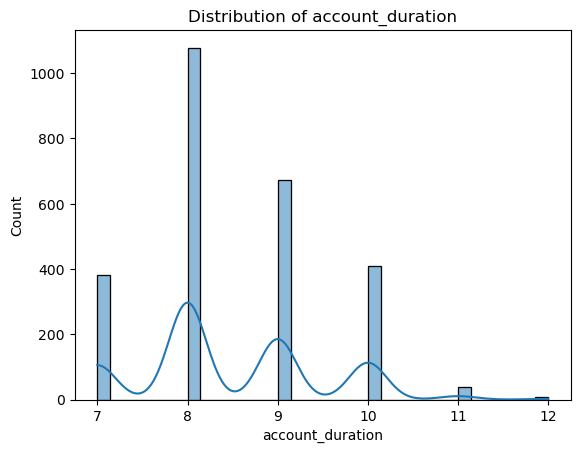

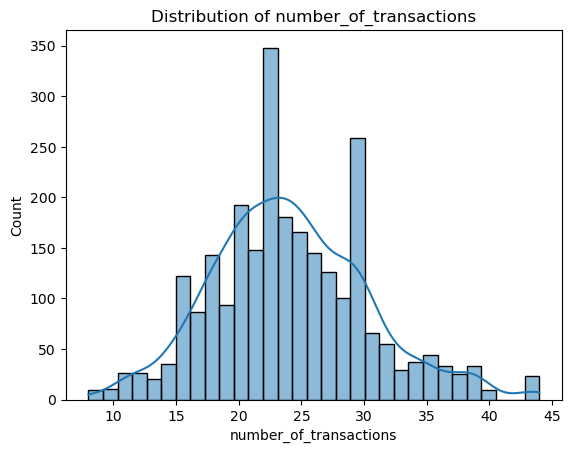

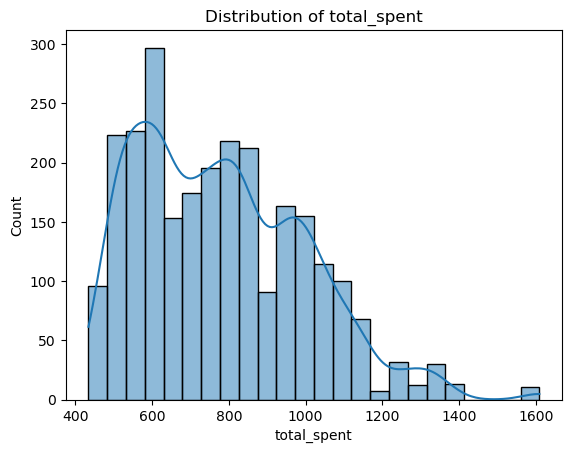

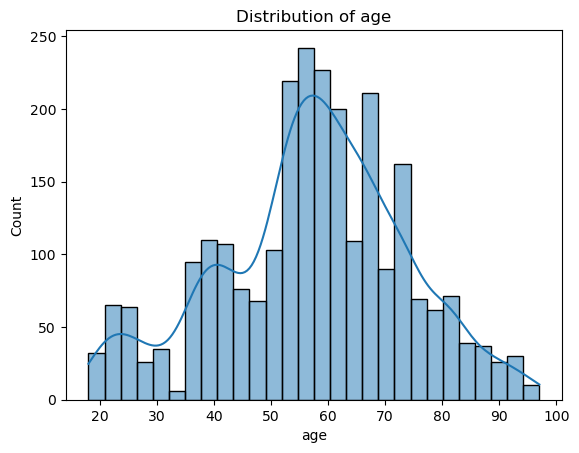

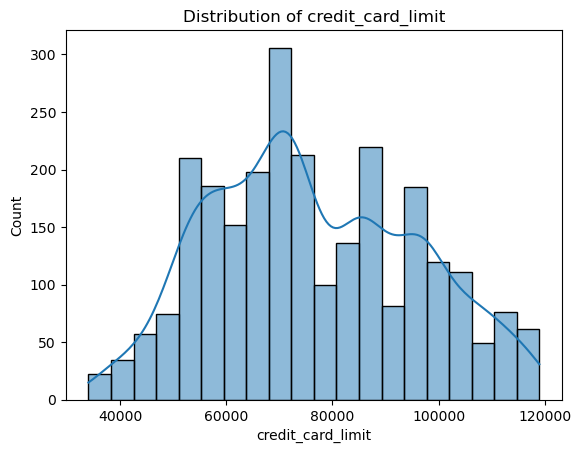

In [57]:
cols = ['account_duration', 'number_of_transactions', 'total_spent', 'age', 'credit_card_limit']

for col in cols:
    sns.histplot(clients2[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

The offers for this cluster are:

In [58]:
offers_group.filter(offers_group.group_offer == 2).show()

+----------+----------+--------------+--------------------+--------+---------+-----------+
|  channels|offer_type|discount_value|            offer_id|duration|min_value|group_offer|
+----------+----------+--------------+--------------------+--------+---------+-----------+
|web, email|  discount|             5|0b1e1539f2cc45b7b...|    10.0|       20|          2|
+----------+----------+--------------+--------------------+--------+---------+-----------+



####4.3 Cluster 3
Clients in this cluster have the following typical characteristics:  
- 9 years of acount_duration in average
- 50% tem entre 18 e 51 anos
- 75% tem entre 30k e 66k `credit_card_limit`
- 25 transactions in average
- 75% of these clients have total_spent 181

In summary, more transactions with medium spends and medium credit_card_limit.


In [59]:
clients3.describe()

,account_duration,age,credit_card_limit,number_of_transactions,total_spent,prediction
count,29725.000000,29725.000000,29725.000000,29725.000000,29725.000000,29725.0
mean,7.614802,50.277679,57057.863751,17.121110,73.981515,3.0
std,0.634630,15.932365,15009.592405,4.162572,52.565522,0.0
min,7.000000,18.000000,30000.000000,6.000000,5.280000,3.0
25%,7.000000,39.000000,45000.000000,14.000000,30.470000,3.0
50%,8.000000,51.000000,57000.000000,17.000000,64.270000,3.0
75%,8.000000,61.000000,69000.000000,20.000000,104.560000,3.0
max,10.000000,100.000000,98000.000000,29.000000,496.720000,3.0


The offers for this cluster are:

In [60]:
offers_group.filter(offers_group.group_offer == 3).show()

+------------------+----------+--------------+--------------------+--------+---------+-----------+
|          channels|offer_type|discount_value|            offer_id|duration|min_value|group_offer|
+------------------+----------+--------------+--------------------+--------+---------+-----------+
|web, email, mobile|      bogo|             5|9b98b8c7a33c4b65b...|     7.0|        5|          3|
|web, email, mobile|  discount|             2|2906b810c7d441179...|     7.0|       10|          3|
+------------------+----------+--------------+--------------------+--------+---------+-----------+

